<a href="https://colab.research.google.com/github/anisha2k/DemandLocator/blob/main/DemandLocator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**INSTALLING THE UNINSTALLED FILES**


In [ ]:
!pip install geopandas
print("geopandas imported!")

     |████████████████████████████████| 1.0 MB 7.4 MB/s 
     |████████████████████████████████| 6.3 MB 48.7 MB/s 
     |████████████████████████████████| 15.4 MB 51.2 MB/s 
geopandas imported!


Importing all the important files to be used

In [ ]:
import requests # library to handle requests
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner
import random # library for random number generation
import geopandas as gpd
import matplotlib.cm as cm
import folium
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image
from IPython.core.display import HTML
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize
print("All packages imported!")

All packages imported!


**READING THE CSV FILE**

In [ ]:
from google.colab import files
uploaded = files.upload()
#dfstudents=pd.read_csv('demandData.csv')

Saving demandData.csv to demandData.csv


In [ ]:
import io
dfstudents = pd.read_csv(io.BytesIO(uploaded['demandData.csv']))
# Dataset is now stored in a Pandas Dataframe

**CLEANING THE DATA**

In [ ]:
#Now we will only use the columns that are useful to us and ignore the others
dfclean=dfstudents[['cook','eating_out','employment','ethnic_food','exercise','fruit_day','income','on_off_campus','pay_meal_out','sports','veggies_day']]
dfclean.dropna(axis=0,inplace=True)
dfclean.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,cook,eating_out,employment,ethnic_food,exercise,fruit_day,income,on_off_campus,pay_meal_out,sports,veggies_day
0,2.0,3,3.0,1,1.0,5,5.0,1.0,2,1.0,5
1,3.0,2,2.0,4,1.0,4,4.0,1.0,4,1.0,4
2,1.0,2,3.0,5,2.0,5,6.0,2.0,3,2.0,5
3,2.0,2,3.0,5,3.0,4,6.0,1.0,2,2.0,3
4,1.0,2,2.0,4,1.0,4,6.0,1.0,4,1.0,4


**IDENTIFYING DIFFERENT TYPES OF STUDENTS**

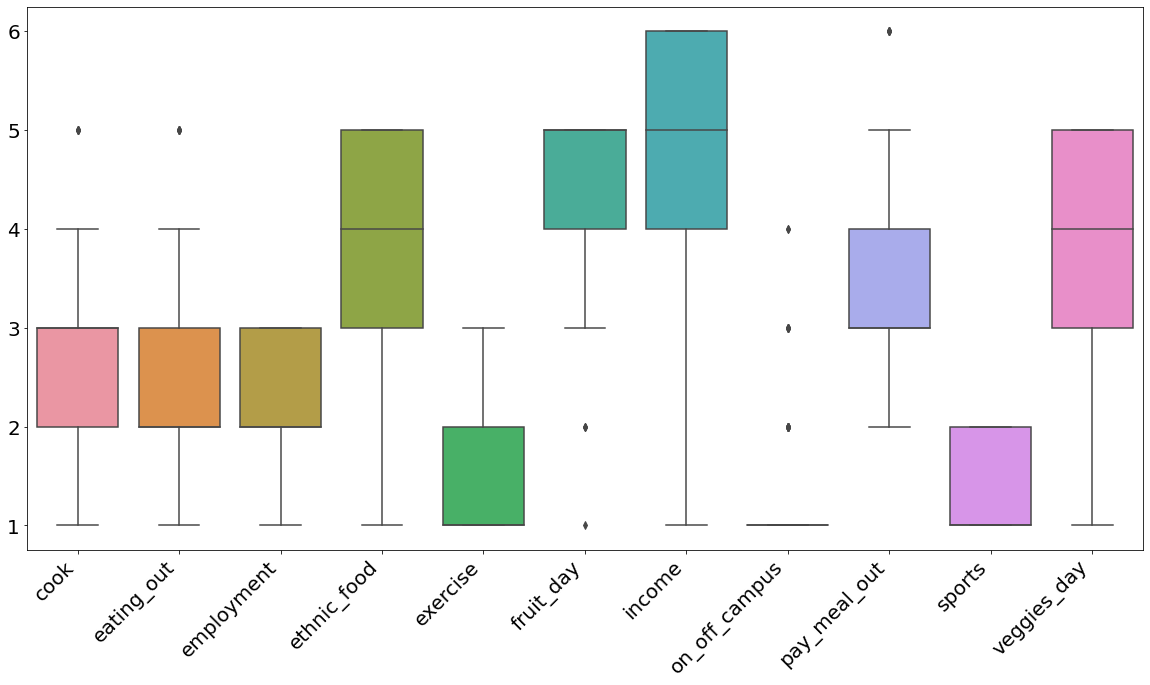

In [ ]:
#Plotting boxplot to analyse the data
plt.figure(figsize=(20, 10))

sns.boxplot

ax = sns.boxplot(data = dfclean)
ax.tick_params(labelsize=20)
plt.xticks(rotation=45, ha='right')

plt.show()

In [ ]:
# set number of clusters
kclusters = 3

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(dfclean)
dfclean['Cluster']=kmeans.labels_

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


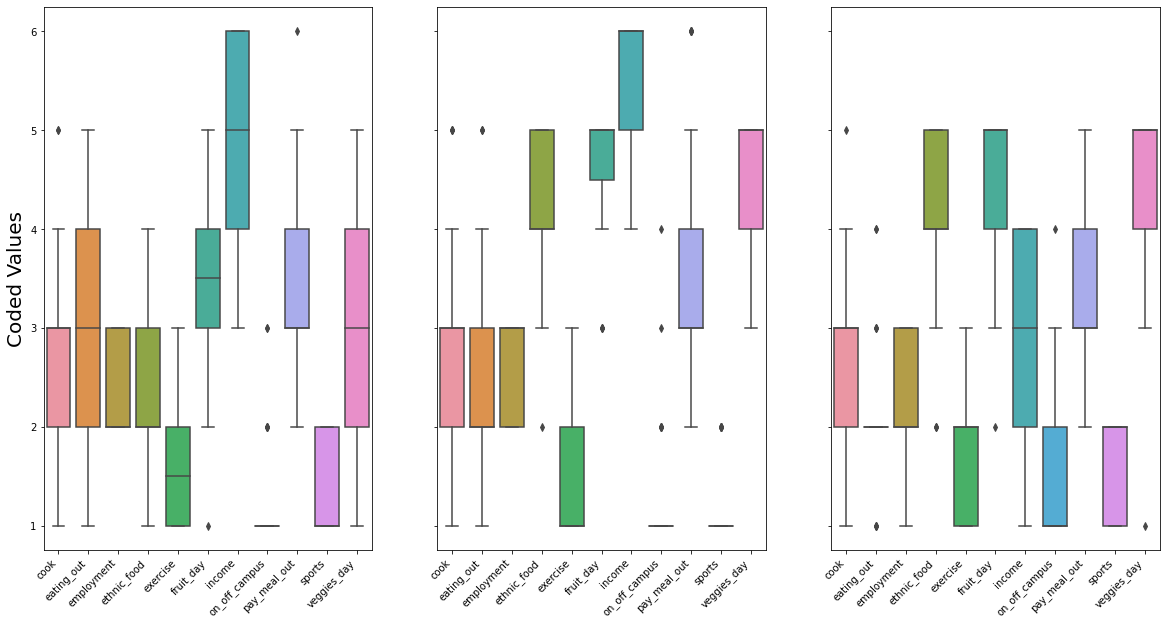

In [ ]:
fig, axes = plt.subplots(1,kclusters, figsize=(20, 10), sharey=True)
axes[0].set_ylabel('Coded Values', fontsize=20)

for k in range(kclusters):
     plt.sca(axes[k])
     plt.xticks(rotation=45,ha='right')
     sns.boxplot(data = dfclean[dfclean['Cluster'] == k].drop('Cluster',1), ax=axes[k])
        
plt.show()

**FINDING STUDENTS A HOME**

 We took the area around our college SRM IST

In [ ]:
search_query = 'Apartment' #Search for residential locations
radius = 18000 #Set the radius to 18 kilometres
latitude=12.8231 #College location
longitude=80.0442

Entered our Foursquare Credentials

In [ ]:
CLIENT_ID = '3I0F2DNV1VNQOFE25MJQBDGMF0IDYJQBPGQZDTTNDMVBQ252'
CLIENT_SECRET = 'BOAZ2MKDRWUKBRV1K5BM33I1XVMK1X0MNPXIPBCXD1H3HZO4' 
VERSION = '20180604'
LIMIT = 200

Now we define the URL

In [ ]:
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query, radius, LIMIT)

We now added the results of the query into a json file

In [ ]:
results = requests.get(url).json()

In [ ]:
# assign relevant part of JSON to venues
venues = results['response']['venues']

# tranform venues into a dataframe
dataframe = json_normalize(venues)
#display(dataframe)
dataframe.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  """


,id,name,categories,referralId,hasPerk,location.address,location.lat,location.lng,location.labeledLatLngs,location.distance,location.postalCode,location.cc,location.city,location.state,location.country,location.formattedAddress,location.crossStreet
0,4d44ec787c555941055220d2,sterling apartment,"[{'id': '4bf58dd8d48988d130941735', 'name': 'B...",v-1641553621,False,"Near E.B. , No 6 GST Road, Guduvanchery",12.842965,80.055892,"[{'label': 'display', 'lat': 12.84296487453112...",2549,603202,IN,Chennai,Tamil Nadu,India,"[Near E.B. , No 6 GST Road, Guduvanchery, Chen...",NaN
1,4e1a41d8ae6092c27663c0de,Abode Valley Apartments,"[{'id': '4d954b06a243a5684965b473', 'name': 'R...",v-1641553621,False,"Near SRM University, Potheri",12.816475,80.040776,"[{'label': 'display', 'lat': 12.81647487860157...",825,603203,IN,Kānchipuram,Tamil Nadu,India,"[Near SRM University, Potheri (Kakkan Street),...",Kakkan Street
2,562b1b32498eccd0b4e19119,Ammu Akshayam Apartment,"[{'id': '4d954b06a243a5684965b473', 'name': 'R...",v-1641553621,False,NaN,12.858193,80.077545,"[{'label': 'display', 'lat': 12.85819339752197...",5325,NaN,IN,NaN,NaN,India,[India],NaN
3,59560e512be425119fff7a35,Amudha Chandran Apartment,"[{'id': '4d954b06a243a5684965b473', 'name': 'R...",v-1641553621,False,NaN,12.916543,80.093004,"[{'label': 'display', 'lat': 12.916543, 'lng':...",11672,NaN,IN,NaN,NaN,India,[India],NaN
4,550d6804498e2cba784c912f,Desh Apartments,"[{'id': '4d954b06a243a5684965b473', 'name': 'R...",v-1641553621,False,GST Road,12.815554,80.084443,"[{'label': 'display', 'lat': 12.81555356551932...",4448,NaN,IN,NaN,NaN,India,"[GST Road, India]",NaN


Filtered the columns according to our requirements

In [ ]:
filtered_columns = ['name', 'categories'] + [col for col in dataframe.columns if col.startswith('location.')] + ['id']
dataframe_filtered = dataframe.loc[:, filtered_columns]

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# filter the category for each row
dataframe_filtered['categories'] = dataframe_filtered.apply(get_category_type, axis=1)

# clean column names by keeping only last term
dataframe_filtered.columns = [column.split('.')[-1] for column in dataframe_filtered.columns]
dataframe_filtered.drop(['cc','country','state','city'],axis=1,inplace=True) #no need for those columns as we know we're in Chennai,IN
dataframe_filtered.head()

,name,categories,address,lat,lng,labeledLatLngs,distance,postalCode,formattedAddress,crossStreet,id
0,sterling apartment,Building,"Near E.B. , No 6 GST Road, Guduvanchery",12.842965,80.055892,"[{'label': 'display', 'lat': 12.84296487453112...",2549,603202,"[Near E.B. , No 6 GST Road, Guduvanchery, Chen...",NaN,4d44ec787c555941055220d2
1,Abode Valley Apartments,Residential Building (Apartment / Condo),"Near SRM University, Potheri",12.816475,80.040776,"[{'label': 'display', 'lat': 12.81647487860157...",825,603203,"[Near SRM University, Potheri (Kakkan Street),...",Kakkan Street,4e1a41d8ae6092c27663c0de
2,Ammu Akshayam Apartment,Residential Building (Apartment / Condo),NaN,12.858193,80.077545,"[{'label': 'display', 'lat': 12.85819339752197...",5325,NaN,[India],NaN,562b1b32498eccd0b4e19119
3,Amudha Chandran Apartment,Residential Building (Apartment / Condo),NaN,12.916543,80.093004,"[{'label': 'display', 'lat': 12.916543, 'lng':...",11672,NaN,[India],NaN,59560e512be425119fff7a35
4,Desh Apartments,Residential Building (Apartment / Condo),GST Road,12.815554,80.084443,"[{'label': 'display', 'lat': 12.81555356551932...",4448,NaN,"[GST Road, India]",NaN,550d6804498e2cba784c912f


Plotting all these points on the map of Chennai

In [ ]:
#define coordinates of the college
map_bang=folium.Map(location=[12.8231,80.0442],zoom_start=12)
# instantiate a feature group for the incidents in the dataframe
locations = folium.map.FeatureGroup()

latitudes = list(dataframe_filtered.lat)
longitudes = list( dataframe_filtered.lng)
labels = list(dataframe_filtered.name)

for lat, lng, label in zip(latitudes, longitudes, labels):
    folium.Marker([lat, lng], popup=label).add_to(map_bang)    
    
# add incidents to map
map_bang.add_child(locations)

map_bang

Figuring out which loactions are ideal on the basis of availability of Restaurants




In [ ]:
df_evaluate=dataframe_filtered[['lat','lng']]

In [ ]:
RestList=[]
latitudes = list(dataframe_filtered.lat)
longitudes = list( dataframe_filtered.lng)
for lat, lng in zip(latitudes, longitudes):    
    radius = 5000 #Set the radius to 5 kilometres for convenience
    latitude=lat #Query for the apartment location in question
    longitude=lng
    url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query, radius, LIMIT)
    search_query = 'Restaurant' #Search for any food related locations
    results = requests.get(url).json()
    # assign relevant part of JSON to venues
    venues = results['response']['venues']
    # tranform venues into a dataframe
    dataframe2 = json_normalize(venues)
    filtered_columns = ['name', 'categories'] + [col for col in dataframe2.columns if col.startswith('location.')] + ['id']
    dataframe_filtered2 = dataframe2.loc[:, filtered_columns]
    # filter the category for each row
    dataframe_filtered2['categories'] = dataframe_filtered2.apply(get_category_type, axis=1)
    # clean column names by keeping only last term
    dataframe_filtered2.columns = [column.split('.')[-1] for column in dataframe_filtered2.columns]
    RestList.append(dataframe_filtered2['categories'].count())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  


In [ ]:
df_evaluate['Restaurants']=RestList

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Performing clustering again on the Restaurants that are near to the campus

In [ ]:
kclusters = 3

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(df_evaluate)
df_evaluate['Cluster']=kmeans.labels_
df_evaluate['Cluster']=df_evaluate['Cluster'].apply(str)
df_evaluate.head(10)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,lat,lng,Restaurants,Cluster
0,12.842965,80.055892,30,2
1,12.816475,80.040776,28,2
2,12.858193,80.077545,21,1
3,12.916543,80.093004,27,2
4,12.815554,80.084443,24,1
5,12.816265,80.084003,24,1
6,12.857877,80.068080,32,2
7,12.850927,80.080652,23,1
8,12.867094,80.071524,25,1
9,12.853354,80.068302,30,2


Plotting the points on the map

In [ ]:
#define coordinates of the college
map_bang=folium.Map(location=[12.8231,80.0442],zoom_start=12)
# instantiate a feature group for the incidents in the dataframe
locations = folium.map.FeatureGroup()
# set color scheme for the clusters
def color_producer(cluster):
    if cluster=='0':
        return 'green'
    elif cluster=='1':
        return 'orange'
    else:
        return 'red'
latitudes = list(df_evaluate.lat)
longitudes = list(df_evaluate.lng)
labels = list(df_evaluate.Cluster)
names=list(dataframe_filtered.name)
for lat, lng, label,names in zip(latitudes, longitudes, labels,names):
    folium.CircleMarker(
            [lat,lng],
            fill=True,
            fill_opacity=1,
            popup=folium.Popup(names, max_width = 300),
            radius=5,
            color=color_producer(label)
        ).add_to(map_bang)

# add locations to map
map_bang.add_child(locations)

map_bang
